# Setup

In [1]:
include(joinpath("..","src","setup.jl"))
datadir = joinpath("..","data","count_lengths","run_2018-11-26")

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/RCall/8GFyb.ji for RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/VegaLite/lrJqi.ji for VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/DataFramesMeta/2xRTO.ji for DataFramesMeta [1313f7d8-7da2-5740-9ea0-a2ca25f37964]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/DependentBootstrap/iCB3r.ji for DependentBootstrap [191d1da1-0f37-5779-b8ea-a655caa0c150]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/AuditoryBistabilityLE/RqG8S.ji for AuditoryBist

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/Feather/RgcL0.ji for Feather [becb17da-46f6-5d3c-ad1b-1c5fe96bc73c]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190
┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1S

"../data/count_lengths/run_2018-11-26"

# TODO: 

- work out the parameters to vary
- run a simulation

## New plans

Once that's done I can work on the New Stimuli notebook and check out context. At that point I can see if the same problem with 12st persists, and really get in to the context stimuli.

In [2]:
params = load_params(joinpath(datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")
settings = TOML.parsefile(settings)

Dict{AbstractString,Any} with 9 entries:
  "percept_lengths" => Dict{AbstractString,Any}("threshold"=>0.2,"min_length_ms…
  "freqs"           => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "mask"            => Dict{AbstractString,Any}("window_ms"=>500,"delta_ms"=>25…
  "rates"           => Dict{AbstractString,Any}("rates_Hz"=>[2, 4, 8, 16, 32],"…
  "scales"          => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "stimulus"        => Dict{AbstractString,Any}("repeats"=>100,"ramp_len_ms"=>1…
  "track"           => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "nmf"             => Dict{AbstractString,Any}("skipframes"=>0,"tol"=>0.001,"w…
  "bandwidth_ratio" => Dict{AbstractString,Any}("window_ms"=>800,"full_band_rat…

In [3]:
results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,23.3,1,2018-11-26T17:38:30.128,1
2,23.3,1,2018-11-26T17:40:27.495,1
3,23.3,1,2018-11-26T17:40:30.437,1
4,23.3,1,2018-11-26T17:40:33.359,1
5,23.3,1,2018-11-26T17:40:36.249,1
6,23.3,1,2018-11-26T17:40:39.153,1


# Object-level build-up

In [31]:
settings["track"]["analyze"]["source_prior_sd_bias"] = [4000,0,0]
settings["track"]["analyze"]["source_prior_strength_bias"] = [4000,0]
settings["stimulus"]["repeats"] = 30

30

In [99]:
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])
p.t_c_σ = 1.2
p.s_c_σ = 1.2
p.f_c_σ = 1.2

p.t_τ_a *= 10
p.t_τ_m *= 10
p.t_τ_σ *= 10
p.s_τ_σ *= 10
p.f_τ_σ *= 10

run1 = bistable_model(p,settings,intermediate_results=true);

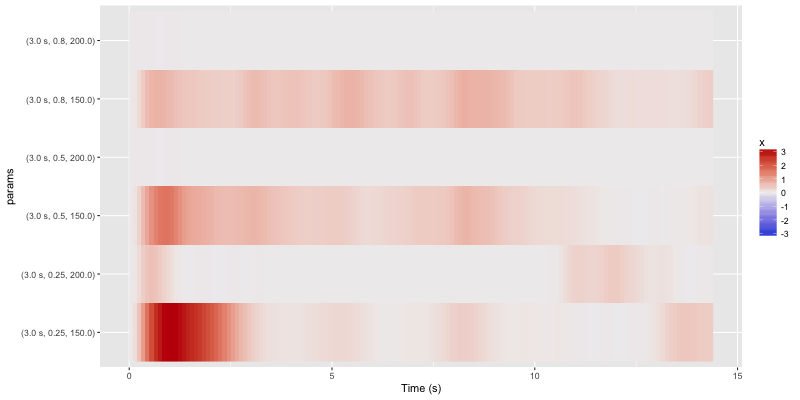

RObject{VecSxp}


In [100]:
rplot(run1.sources.outweights)

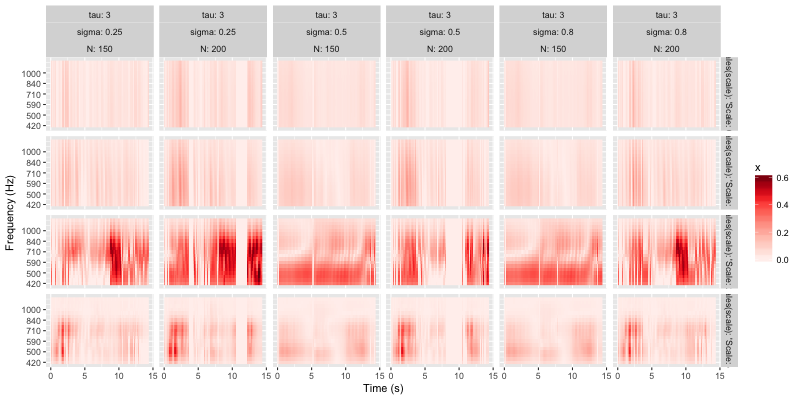

RObject{VecSxp}


In [101]:
rplot(run1.sources.tracks)

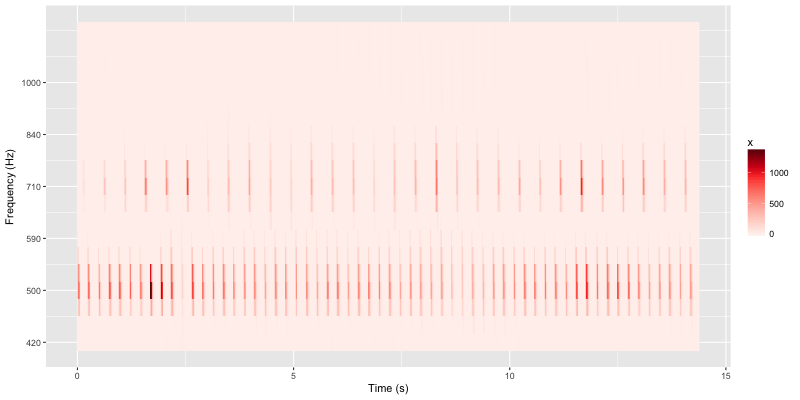

RObject{VecSxp}


In [102]:
rplot(run1.primary_source)

In [103]:
run1.percepts.counts

([0.9, 1.7, 5.0, 0.7, 2.6, 2.3, 0.5], Bool[true, false, true, false, true, false, true])

In [36]:
using Logging

In [105]:
result = []
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])
p.t_c_σ = 1.2
p.s_c_σ = 1.2
p.f_c_σ = 1.2

# could it be that I need to change the time constants for the s_ and f_ parameters as well?

p.t_τ_a *= 25
p.t_τ_m *= 25
p.t_τ_σ *= 25
p.s_τ_σ *= 25
p.t_τ_σ *= 25

@showprogress for i in 1:100
    with_logger(NullLogger()) do
        len,val = bistable_model(p,settings,intermediate_results=true).percepts.counts
        push!(result,DataFrame(length=len,response=val.+1,run=i))
    end
end
buildup = vcat(result...);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:24


In [106]:
sdf = buildup_mean(buildup,delta=0.24,length=14);

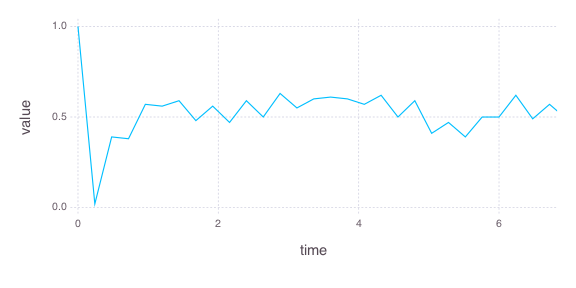

false

In [107]:
draw(PNG(6inch,3inch),plot(sdf,x=:time,y=:value,Geom.line,Coord.cartesian(ymax=1.0,xmax=6.72)))

In [ ]:
result = []
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])
p.t_c_σ = 1.2
p.s_c_σ = 1.2
p.f_c_σ = 1.2

@showprogress for i in 1:100
    with_logger(NullLogger()) do
        len,val = bistable_model(p,settings,intermediate_results=true).percepts.counts
        push!(result,DataFrame(length=len,response=val.+1,run=i))
    end
end
buildup = vcat(result...);

In [48]:
sdf = buildup_mean(buildup,delta=0.24,length=14);

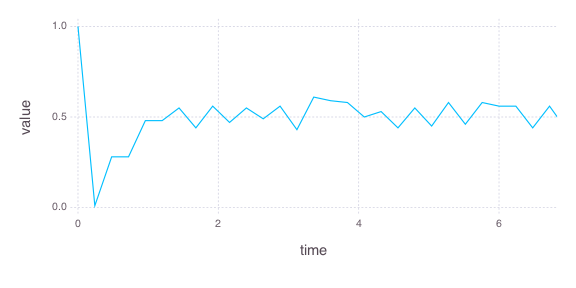

false

In [49]:
draw(PNG(6inch,3inch),plot(sdf,x=:time,y=:value,Geom.line,Coord.cartesian(ymax=1.0,xmax=6.72)))

In [15]:
hdf = CSV.read(joinpath("..","analysis","context","exp1A.csv"))
head(hdf)

,Column1,sid,sample,time,context_A,context_B,st,test_A,test_B,response,same_freq
,Int64⍰,String⍰,Int64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰
1,1,CK,1,0.24,1,1,0,300,424,0,FALSE
2,2,CK,2,0.48,1,1,0,300,424,0,FALSE
3,3,CK,3,0.72,1,1,0,300,424,0,FALSE
4,4,CK,4,0.96,1,1,0,300,424,0,FALSE
5,5,CK,5,1.2,1,1,0,300,424,0,FALSE
6,6,CK,6,1.44,1,1,0,300,424,0,FALSE


In [16]:
delta = diff(hdf.time[1:2])[1]

0.24

In [ ]:
okay, that seems to be a very sudden transition. Does this transition depend on the time constant?

In [ ]:
I coudl setup a very simple run to do this on the server, shouldn't take long

In [17]:
hdf_mean = @linq hdf |>
  where((:st .== 6) .& (:same_freq.=="TRUE")) |>
  by(:time,response = mean(:response))
head(hdf_mean)

,time,response
,Float64⍰,Float64
1,0.24,0.0
2,0.48,0.0
3,0.72,0.0
4,0.96,0.0
5,1.2,0.00925926
6,1.44,0.037037


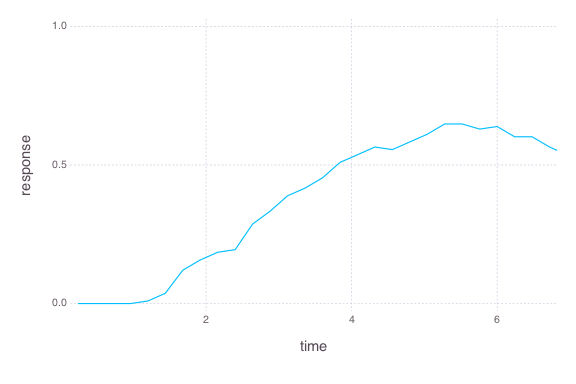

false

In [18]:
draw(PNG(6inch,4inch),plot(hdf_mean,x=:time,y=:response,Geom.line,Coord.cartesian(xmax=6.72,ymax=1.0)))

In [19]:
rms(sdf.value[0.0 .< sdf.time .< 6.72] .- hdf_mean.response[hdf_mean.time .< 6.72])

0.22114674596182657